In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 50

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
# META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"
META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 30

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [14]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [15]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [29]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    if light == False:
        compute_and_print_steps(sats, RandomVarDPLL)
        compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, HybridDPLL)
    if light == False:
        compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

 20%|██        | 2/10 [00:00<00:00, 18.05it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 33.94it/s]


#Sats: 10; avg step: 619.70; stdev step: 327.30; avg error: 7.40; stdev error: 1.96


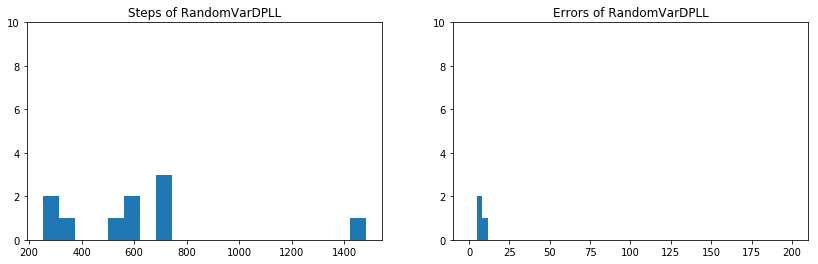

100%|██████████| 10/10 [00:00<00:00, 40.54it/s]


#Sats: 10; avg step: 636.80; stdev step: 334.00; avg error: 4.80; stdev error: 2.48


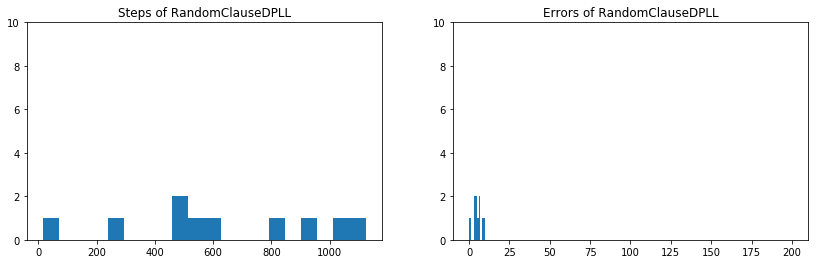

100%|██████████| 10/10 [00:21<00:00,  2.07s/it]


#Sats: 10; avg step: 155.40; stdev step: 194.16; avg error: 1.00; stdev error: 1.41


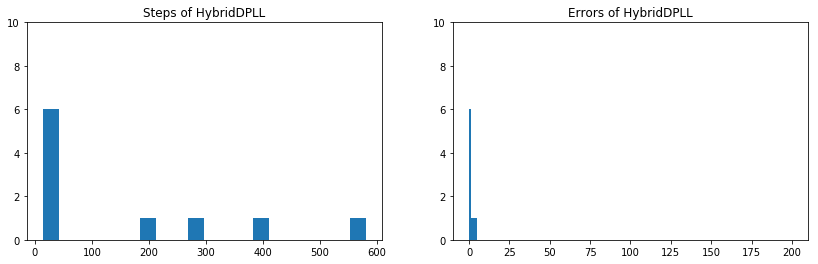

100%|██████████| 10/10 [00:35<00:00,  4.62s/it]


#Sats: 10; avg step: 177.50; stdev step: 227.79; avg error: 0.40; stdev error: 0.49


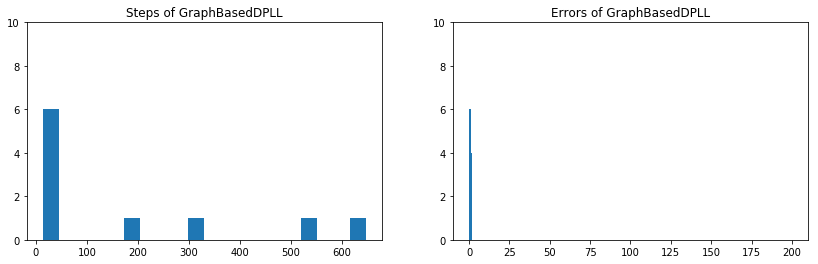

100%|██████████| 10/10 [00:00<00:00, 77.21it/s]


#Sats: 10; avg step: 227.20; stdev step: 135.79; avg error: 3.00; stdev error: 1.26


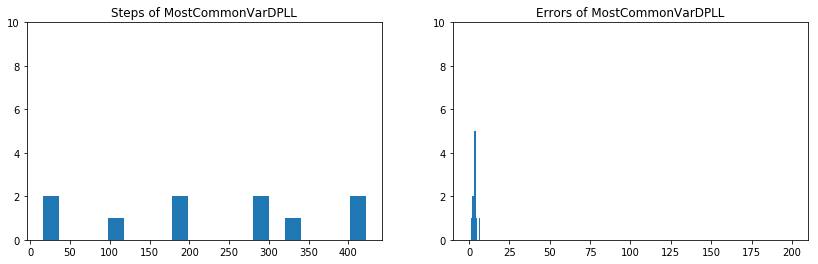

In [17]:
print_all(10, 200, 15)

100%|██████████| 10/10 [00:00<00:00, 569.27it/s]


We have generated 10 formulas
#Sats: 10; avg step: 60.80; stdev step: 39.44; avg error: 3.60; stdev error: 1.62


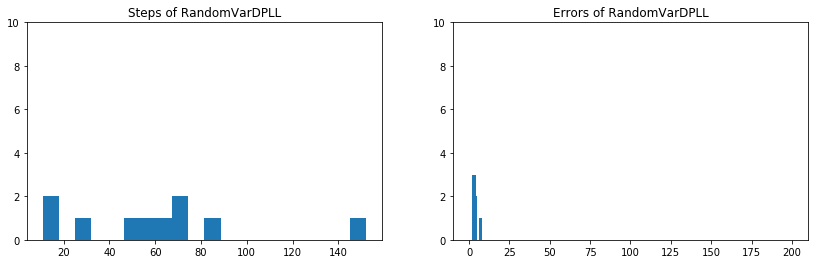

100%|██████████| 10/10 [00:00<00:00, 567.04it/s]


#Sats: 10; avg step: 59.90; stdev step: 34.14; avg error: 3.10; stdev error: 0.94


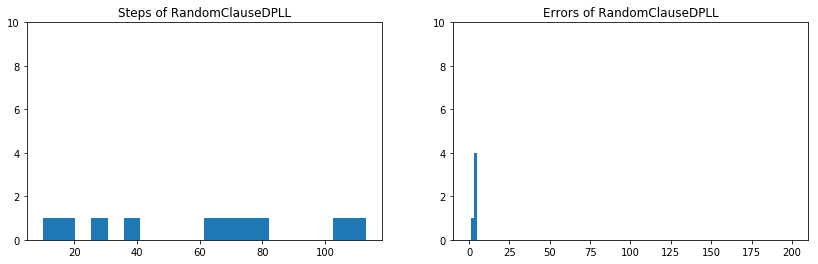

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


#Sats: 10; avg step: 25.20; stdev step: 33.39; avg error: 0.20; stdev error: 0.40


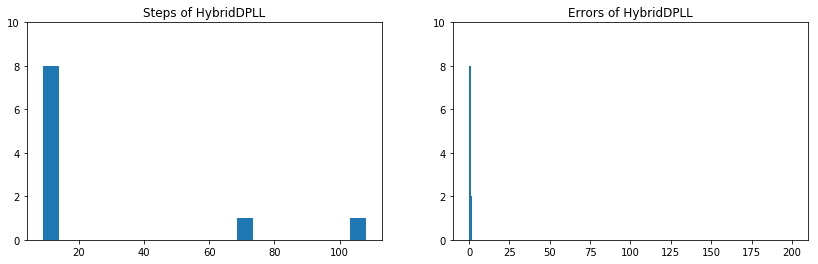

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


#Sats: 10; avg step: 25.20; stdev step: 33.39; avg error: 0.20; stdev error: 0.40


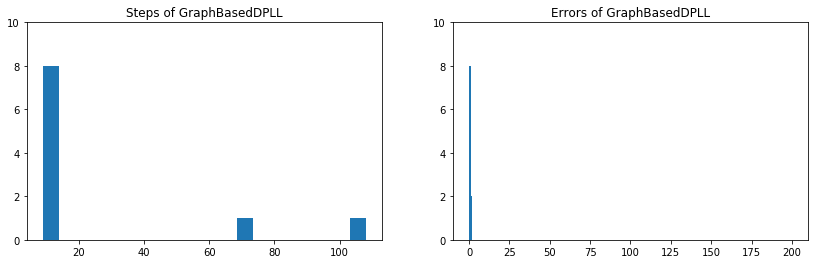

100%|██████████| 10/10 [00:00<00:00, 535.19it/s]


#Sats: 10; avg step: 35.30; stdev step: 17.07; avg error: 1.10; stdev error: 0.54


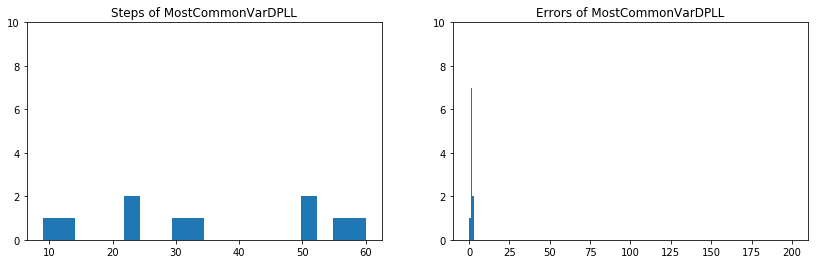

In [18]:
print_all(10, 200, 8)

100%|██████████| 10/10 [00:00<00:00, 201.30it/s]


We have generated 10 formulas
#Sats: 10; avg step: 145.20; stdev step: 90.85; avg error: 5.20; stdev error: 1.08


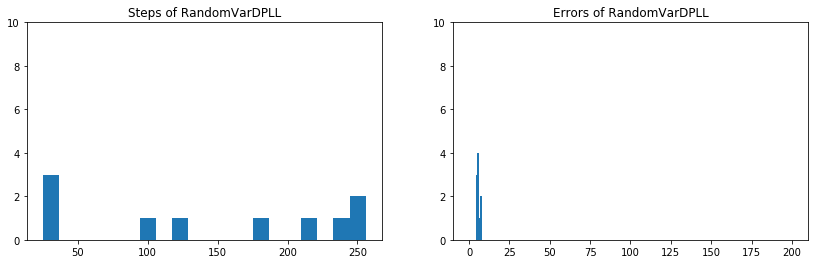

100%|██████████| 10/10 [00:00<00:00, 244.11it/s]


#Sats: 10; avg step: 116.50; stdev step: 87.69; avg error: 3.70; stdev error: 1.55


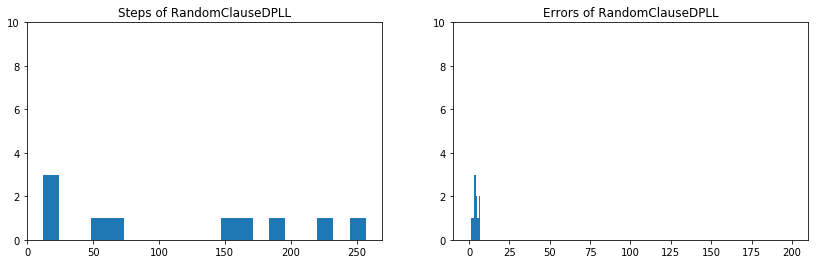

100%|██████████| 10/10 [00:11<00:00,  1.18it/s]


#Sats: 10; avg step: 62.30; stdev step: 75.34; avg error: 0.50; stdev error: 0.67


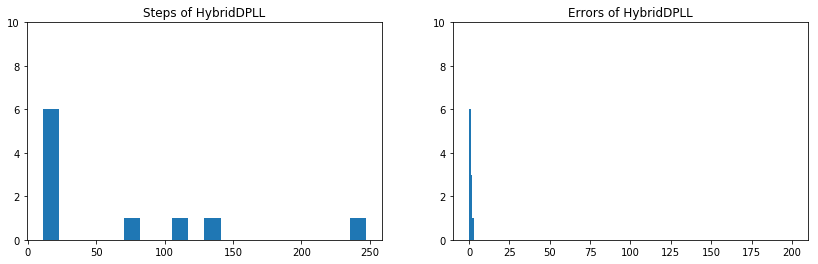

100%|██████████| 10/10 [00:12<00:00,  1.17it/s]


#Sats: 10; avg step: 59.20; stdev step: 67.96; avg error: 0.40; stdev error: 0.49


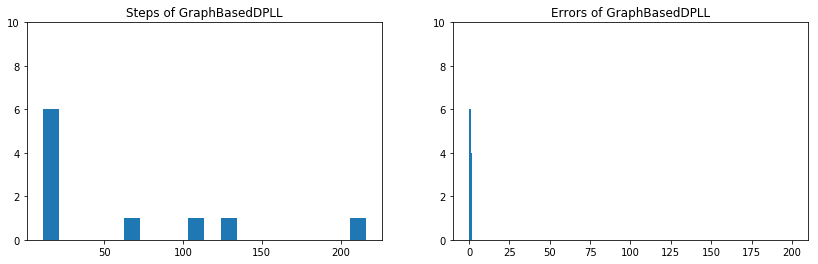

100%|██████████| 10/10 [00:00<00:00, 340.87it/s]


#Sats: 10; avg step: 64.80; stdev step: 53.51; avg error: 1.80; stdev error: 1.08


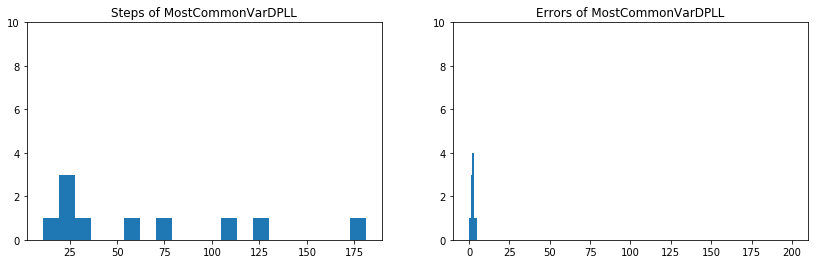

In [19]:
print_all(10, 200, 10)

100%|██████████| 10/10 [00:00<00:00, 49.96it/s]

We have generated 10 formulas


#Sats: 10; avg step: 438.30; stdev step: 279.72; avg error: 6.80; stdev error: 0.75


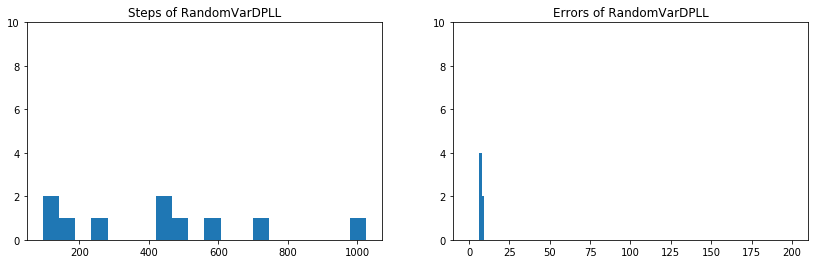

100%|██████████| 10/10 [00:00<00:00, 182.21it/s]


#Sats: 10; avg step: 156.30; stdev step: 108.56; avg error: 3.30; stdev error: 1.27


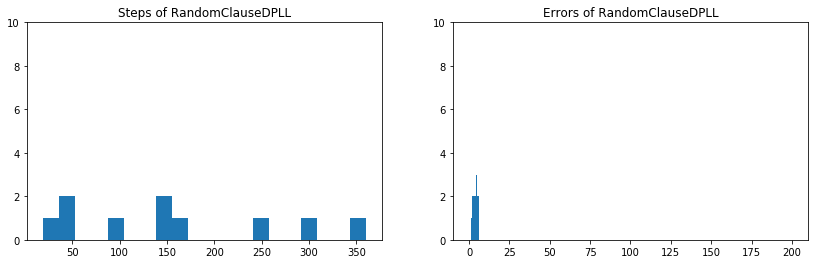

100%|██████████| 10/10 [00:13<00:00,  1.22s/it]


#Sats: 10; avg step: 96.70; stdev step: 137.01; avg error: 0.70; stdev error: 0.78


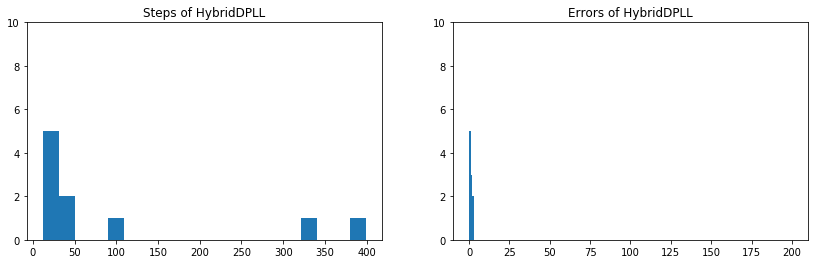

100%|██████████| 10/10 [00:27<00:00,  2.46s/it]


#Sats: 10; avg step: 142.10; stdev step: 226.17; avg error: 0.70; stdev error: 0.78


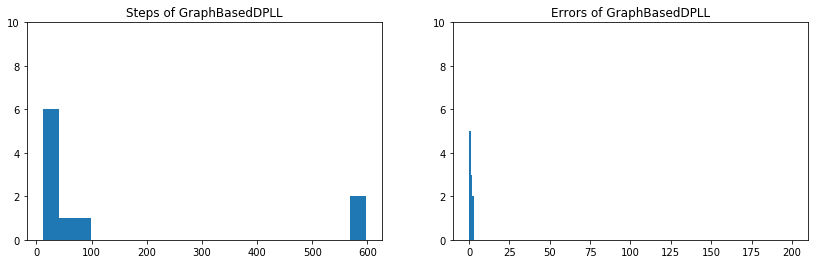

100%|██████████| 10/10 [00:00<00:00, 168.03it/s]


#Sats: 10; avg step: 113.70; stdev step: 78.38; avg error: 2.10; stdev error: 1.37


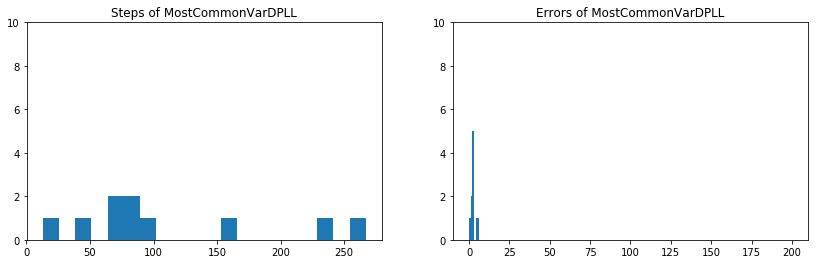

In [20]:
print_all(10, 200, 12)

 70%|███████   | 7/10 [00:00<00:00, 22.17it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 33.56it/s]


#Sats: 10; avg step: 574.40; stdev step: 409.14; avg error: 6.50; stdev error: 2.66


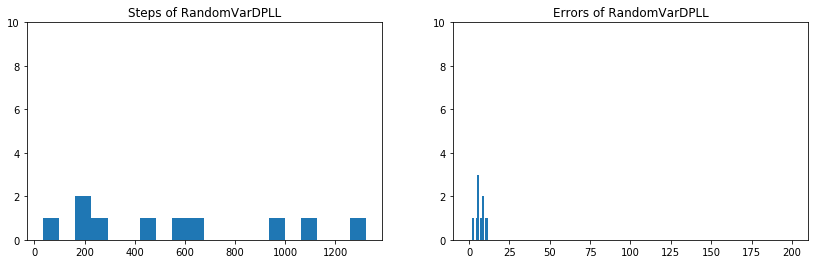

100%|██████████| 10/10 [00:00<00:00, 66.28it/s]


#Sats: 10; avg step: 308.80; stdev step: 233.24; avg error: 4.90; stdev error: 1.30


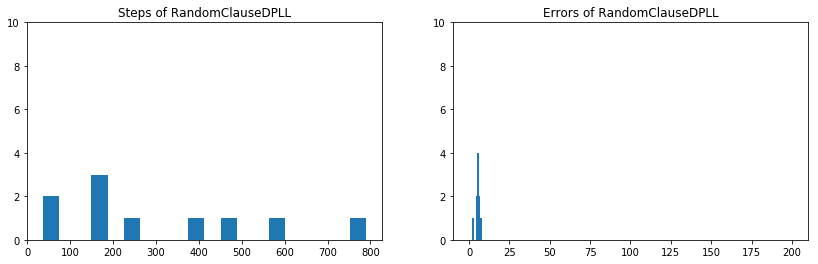

100%|██████████| 10/10 [00:18<00:00,  1.16s/it]


#Sats: 10; avg step: 163.50; stdev step: 220.73; avg error: 0.80; stdev error: 1.08


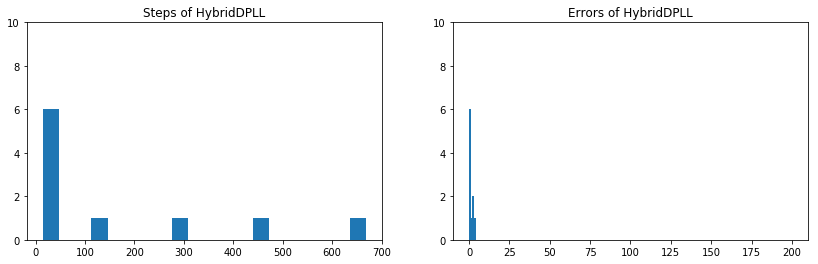

100%|██████████| 10/10 [00:47<00:00,  2.04s/it]


#Sats: 10; avg step: 226.00; stdev step: 326.59; avg error: 0.50; stdev error: 0.67


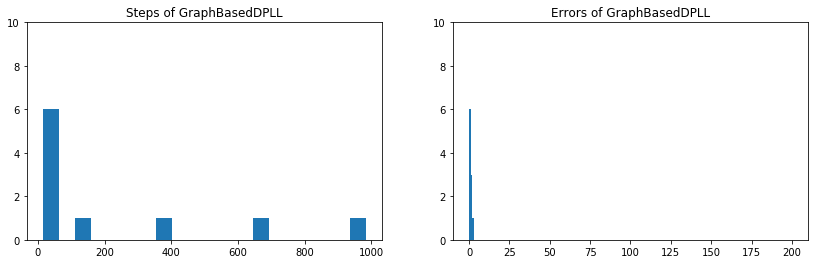

100%|██████████| 10/10 [00:00<00:00, 54.81it/s]


#Sats: 10; avg step: 183.40; stdev step: 93.84; avg error: 1.90; stdev error: 0.70


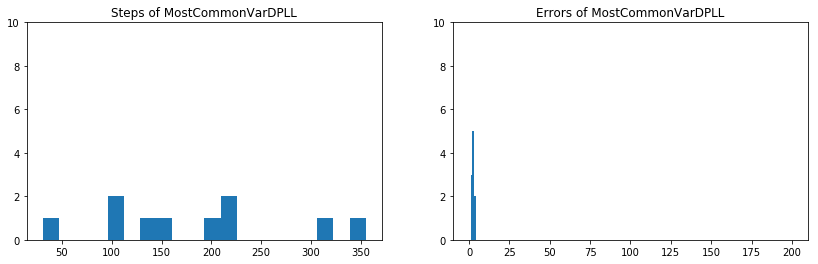

In [21]:
print_all(10, 200, 14)

 50%|█████     | 5/10 [00:00<00:00, 15.79it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 15.77it/s]


#Sats: 10; avg step: 1410.00; stdev step: 617.93; avg error: 8.60; stdev error: 1.80


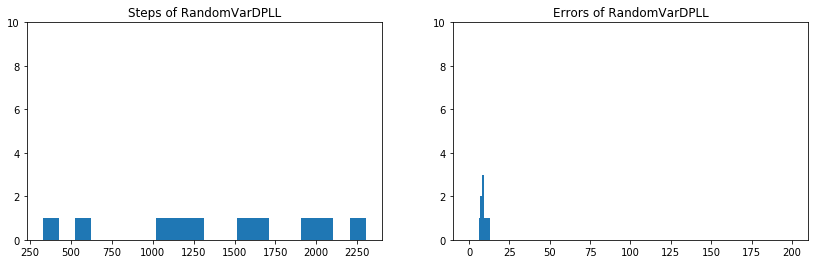

100%|██████████| 10/10 [00:00<00:00, 24.01it/s]


#Sats: 10; avg step: 1016.00; stdev step: 534.46; avg error: 5.80; stdev error: 1.47


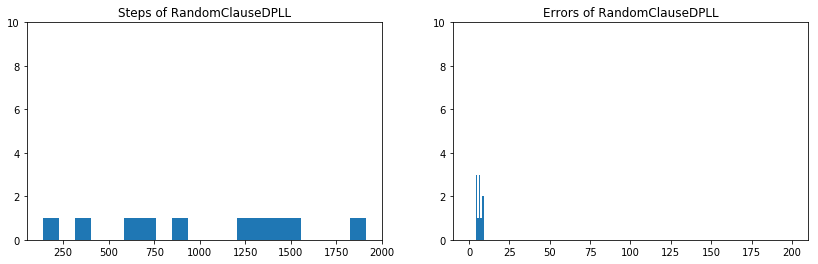

100%|██████████| 10/10 [00:26<00:00,  2.79s/it]


#Sats: 10; avg step: 431.70; stdev step: 488.91; avg error: 1.60; stdev error: 1.74


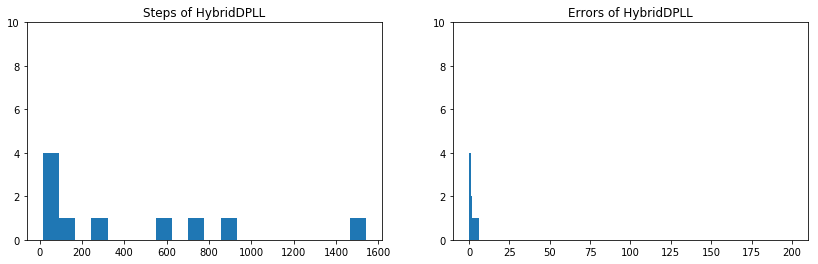

100%|██████████| 10/10 [03:13<00:00, 24.22s/it]


#Sats: 10; avg step: 967.50; stdev step: 1134.38; avg error: 0.70; stdev error: 0.64


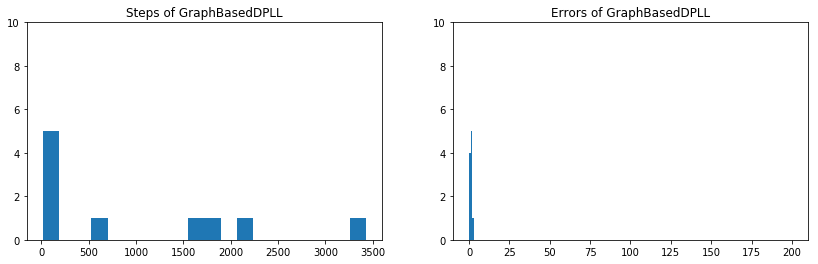

100%|██████████| 10/10 [00:00<00:00, 34.02it/s]


#Sats: 10; avg step: 299.90; stdev step: 331.15; avg error: 3.00; stdev error: 1.18


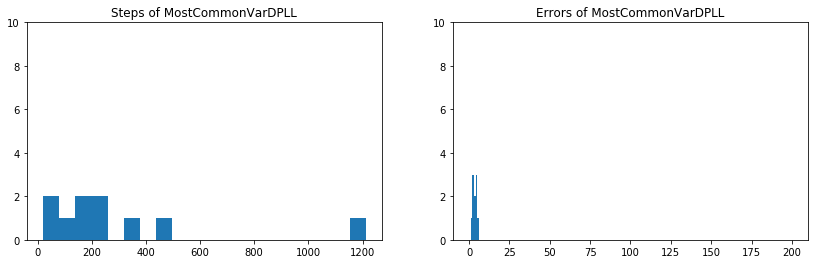

In [22]:
print_all(10, 200, 16)

 10%|█         | 1/10 [00:00<00:01,  4.87it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


#Sats: 10; avg step: 3257.20; stdev step: 1707.45; avg error: 10.20; stdev error: 1.60


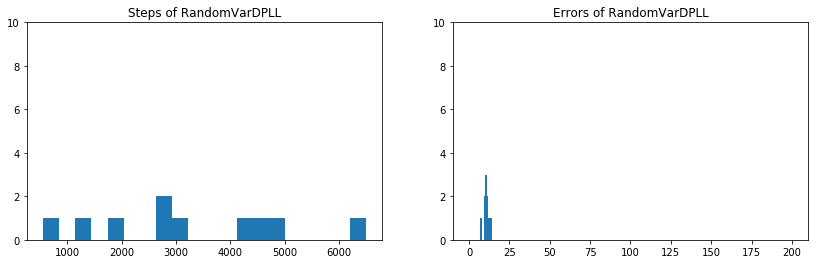

100%|██████████| 10/10 [00:00<00:00, 11.23it/s]


#Sats: 10; avg step: 1379.10; stdev step: 905.13; avg error: 4.70; stdev error: 1.49


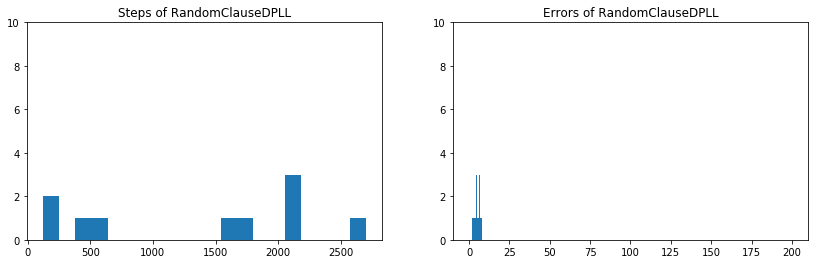

100%|██████████| 10/10 [00:18<00:00,  1.38s/it]


#Sats: 10; avg step: 262.10; stdev step: 425.35; avg error: 1.10; stdev error: 1.81


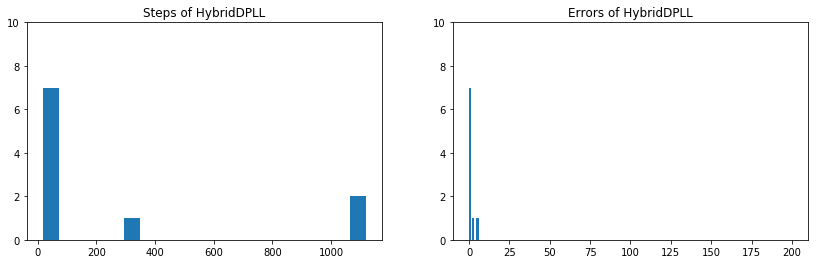

100%|██████████| 10/10 [01:39<00:00,  6.11s/it]


#Sats: 10; avg step: 452.10; stdev step: 742.60; avg error: 0.50; stdev error: 0.92


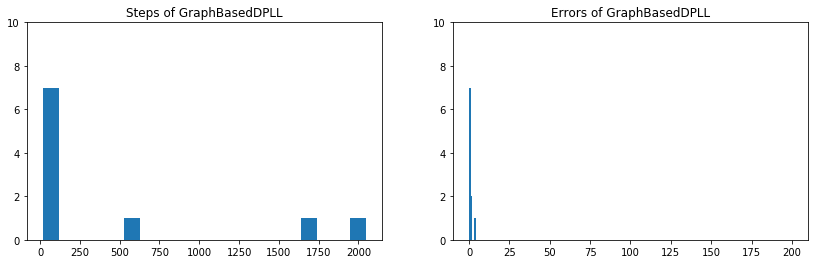

100%|██████████| 10/10 [00:00<00:00, 19.21it/s]


#Sats: 10; avg step: 631.70; stdev step: 461.62; avg error: 3.40; stdev error: 1.85


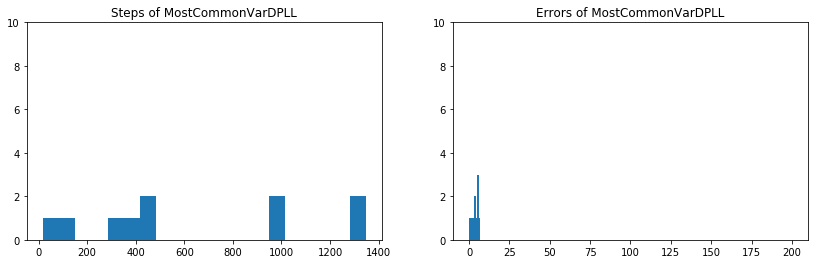

In [23]:
print_all(10, 200, 18)

 20%|██        | 2/10 [00:00<00:02,  3.77it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


#Sats: 10; avg step: 3793.50; stdev step: 3468.09; avg error: 8.70; stdev error: 2.53


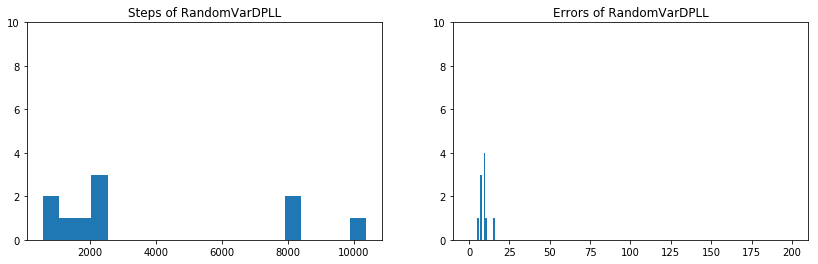

100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


#Sats: 10; avg step: 2196.30; stdev step: 1894.29; avg error: 4.70; stdev error: 1.73


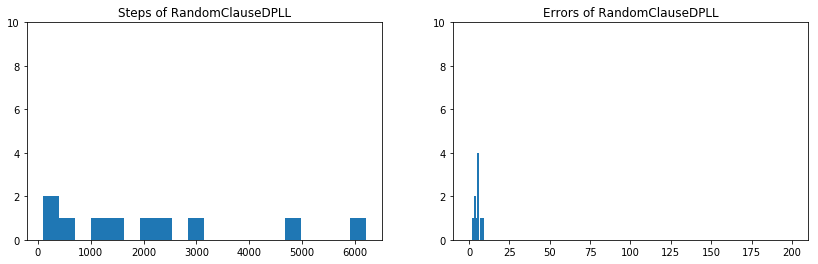

100%|██████████| 10/10 [00:23<00:00,  1.66s/it]


#Sats: 10; avg step: 792.60; stdev step: 1266.40; avg error: 1.60; stdev error: 2.15


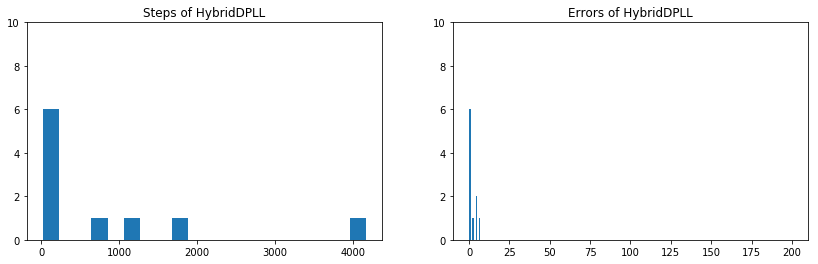

100%|██████████| 10/10 [07:34<00:00, 24.09s/it]


#Sats: 10; avg step: 1902.10; stdev step: 2826.98; avg error: 0.50; stdev error: 0.67


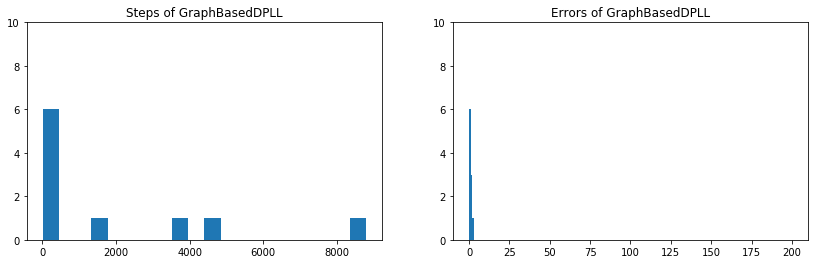

100%|██████████| 10/10 [00:01<00:00,  9.19it/s]


#Sats: 10; avg step: 1217.10; stdev step: 531.25; avg error: 3.50; stdev error: 1.36


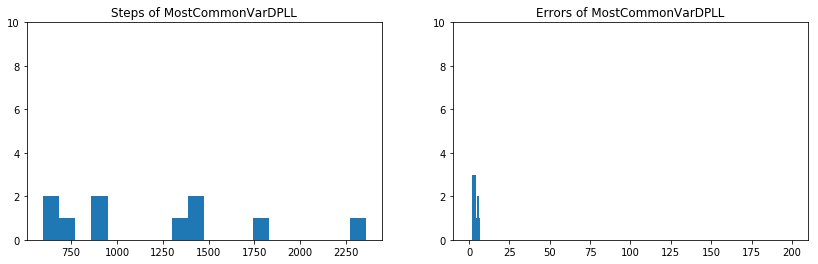

In [24]:
print_all(10, 200, 20)

 10%|█         | 1/10 [00:00<00:08,  1.09it/s]

We have generated 10 formulas



100%|██████████| 10/10 [00:11<00:00,  1.30s/it]


#Sats: 10; avg step: 16519.40; stdev step: 20067.36; avg error: 10.80; stdev error: 2.40


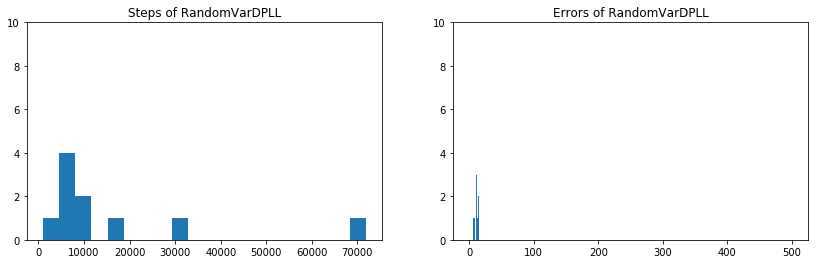

100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


#Sats: 10; avg step: 6112.40; stdev step: 5491.56; avg error: 7.00; stdev error: 2.53


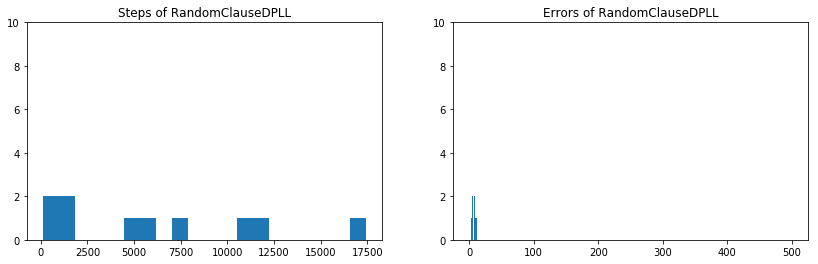

100%|██████████| 10/10 [00:43<00:00,  4.89s/it]


#Sats: 10; avg step: 1773.90; stdev step: 2747.73; avg error: 2.40; stdev error: 1.85


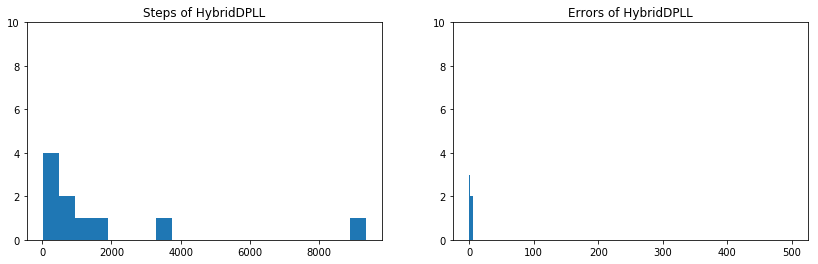

100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


#Sats: 10; avg step: 2372.70; stdev step: 2199.01; avg error: 3.30; stdev error: 1.62


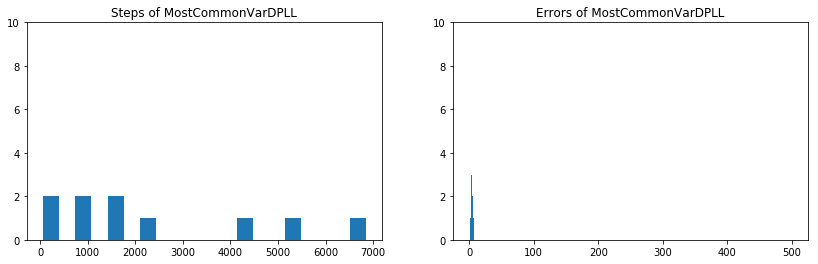

In [25]:
print_all(10, 500, 25, light=True)

 10%|█         | 1/10 [00:05<00:47,  5.29s/it]

We have generated 10 formulas



100%|██████████| 10/10 [01:32<00:00,  6.61s/it]


#Sats: 10; avg step: 116320.10; stdev step: 91179.96; avg error: 13.80; stdev error: 2.52


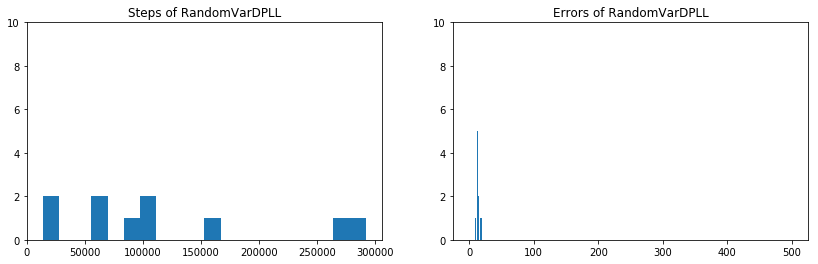

100%|██████████| 10/10 [00:51<00:00,  6.04s/it]


#Sats: 10; avg step: 54408.80; stdev step: 27369.07; avg error: 9.80; stdev error: 2.86


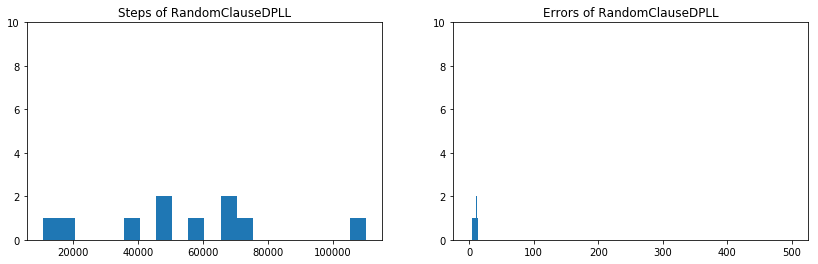

100%|██████████| 10/10 [00:48<00:00,  5.10s/it]


#Sats: 10; avg step: 4392.60; stdev step: 6539.25; avg error: 2.80; stdev error: 2.71


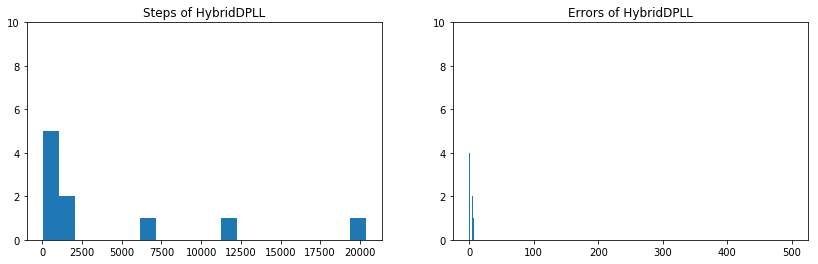

100%|██████████| 10/10 [00:10<00:00,  1.05it/s]


#Sats: 10; avg step: 10113.60; stdev step: 11080.51; avg error: 4.60; stdev error: 1.91


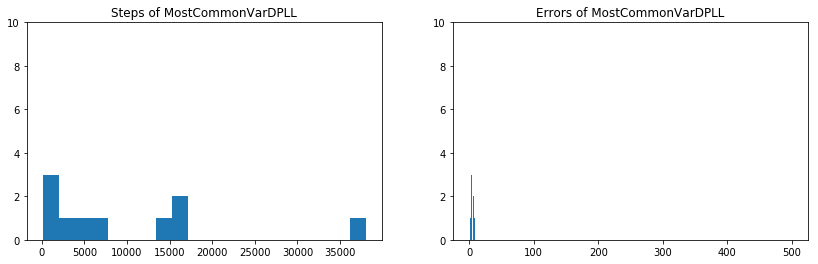

In [26]:
print_all(10, 500, 30, light=True)

 10%|█         | 1/10 [07:46<1:10:01, 466.79s/it]

We have generated 10 formulas


100%|██████████| 10/10 [58:56<00:00, 334.83s/it] 


#Sats: 10; avg step: 3685981.00; stdev step: 2947553.75; avg error: 18.80; stdev error: 2.89


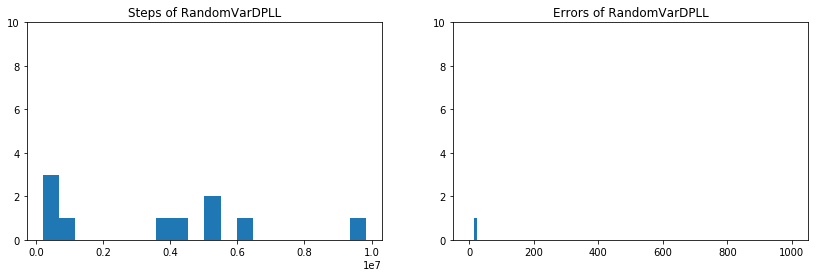

100%|██████████| 10/10 [29:07<00:00, 175.03s/it]


#Sats: 10; avg step: 1610176.40; stdev step: 1111894.55; avg error: 11.70; stdev error: 2.76


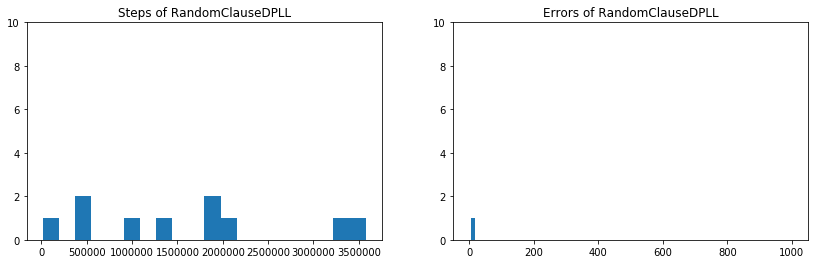

100%|██████████| 10/10 [06:03<00:00, 47.28s/it]


#Sats: 10; avg step: 237285.70; stdev step: 261579.45; avg error: 5.00; stdev error: 3.66


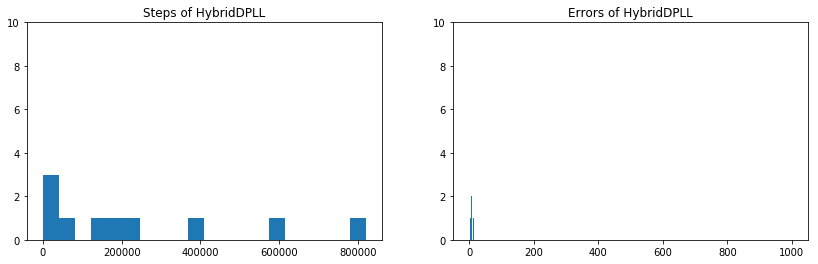

100%|██████████| 10/10 [07:23<00:00, 37.00s/it]


#Sats: 10; avg step: 323427.90; stdev step: 296310.29; avg error: 6.10; stdev error: 2.59


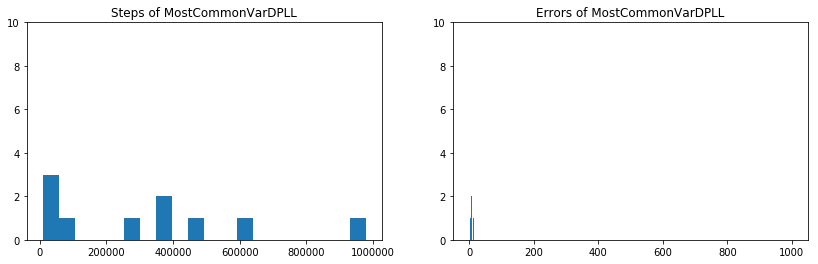

In [27]:
print_all(10, 1000, 40, light=True)


  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas



100%|██████████| 10/10 [23:44<00:00, 178.34s/it]


#Sats: 10; avg step: 1093505.90; stdev step: 1820967.56; avg error: 3.90; stdev error: 4.93


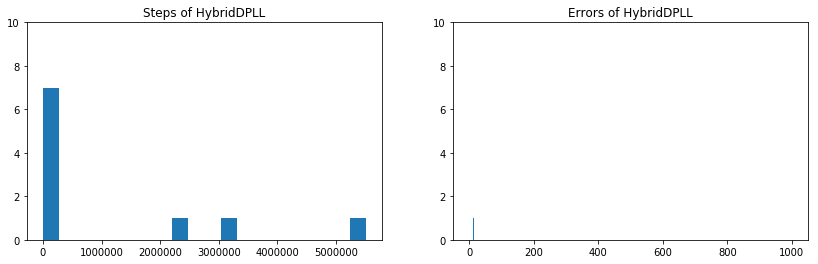

100%|██████████| 10/10 [1:37:07<00:00, 534.13s/it]


#Sats: 10; avg step: 3907982.20; stdev step: 3050280.58; avg error: 7.50; stdev error: 2.06


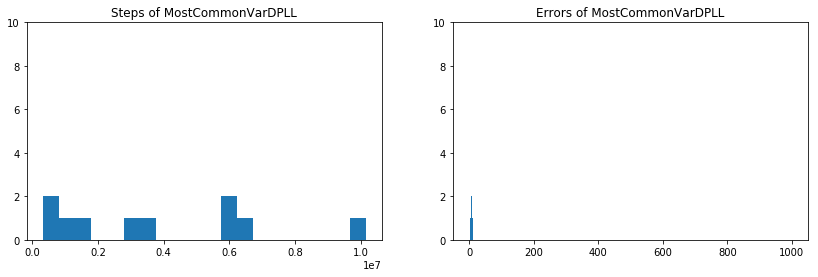

In [30]:
print_all(10, 1000, 50, light=True)

In [ ]:
print_all(10, 1000, 70, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


 10%|█         | 1/10 [00:12<01:52, 12.44s/it]

In [ ]:
print_all(10, 1000, 90, light=True)

In [ ]:
print_all(10, 1000, 40, light=True)